- 1. 从零实现

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
from torch import nn

# 定义批量规范化层

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps=1e-5, momentum=0.9):
    """
    :param X:               输入数据集
    :param gamma:           拉伸参数(scale)
    :param beta:            偏移参数(shift)
    gamma、beta 形状和 X相同
    :param moving_mean:     移动均值, 训练之后得到的 x_hat
    :param moving_var:      移动方差, 训练之后得到的 σ
    :param eps:             小的常量 ϵ
    :param momentum:        调整 moving_mean、moving_var 的参数
    :return:
    """
    if torch.is_grad_enabled():
        X_hat = (X - moving_mean)/torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4) # 输入数据集的维度为2或4
        if len(X.shape) == 2:
            # X 的维度是2, 计算 X 的均值和方差
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X- mean) ** 2.0).mean(dim=0)
        else:
            # X 的维度是4, 计算 X 的均值和方差, 除了通道不计算，其它的都需要计算
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2.0).mean(dim=(0, 2, 3), keepdim=True)
        # 利用计算的 均值 和 方差 计算标准化
        X_hat = (X - mean)/torch.sqrt(var + eps)
        # 更新移动均值和方差
        moving_mean = moving_mean * momentum + (1 - momentum) * mean
        moving_var = moving_var * momentum + (1 - momentum) * var

    # # 缩放和移位
    Y = gamma * X_hat + beta
    return Y, moving_mean, moving_var

class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
           shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)

        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var)
        return Y

- 使用批量规范化层的 LeNet

使用6.6节 卷积神经网络 的 LeNet 模型

在卷积层后面添加 批量规范化层, 对输入数据进行批量规范化

loss 0.594, train acc 0.769, test acc 0.754
55998.7 examples/sec on cuda:0


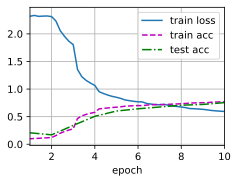

In [2]:
net = nn.Sequential(
    # BatchNorm层 卷积层、全链路层 输出的通道数 或 参数数目
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),

    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

# X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__,'output shape: \t',X.shape)


from d2l import torch as d2l

lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())



In [6]:
print(net[1].gamma.reshape(-1))

print(net[1].beta.reshape(-1))

tensor([2.8940, 3.5122, 3.6080, 2.3256, 3.0654, 3.4973], device='cuda:0',
       grad_fn=<ViewBackward0>)
tensor([ 0.8653,  0.4712, -3.8275, -0.8690,  0.9845, -3.5329], device='cuda:0',
       grad_fn=<ViewBackward0>)


- 2. 简明实现

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import torch
from torch import nn

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),

    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

# net.eval() # 如果不是评估模式, 下面查询shape会提示错误, 如果不设置这行代码, 可以将下面的size=(2, 1, 28, 28)
# X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__,'output shape: \t',X.shape)

loss 0.275, train acc 0.899, test acc 0.847
41402.1 examples/sec on cuda:0


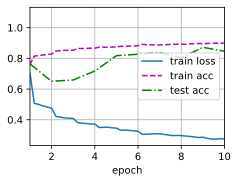

In [2]:
from d2l import torch as d2l

lr, num_epochs, batch_size = 0.5, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())